# Deep learning CA - 01
### Module Code: B9AI104
### Module Title: B9AI104 Deep Learning

#### Divyakumar Nanjunda - 10592474

#### Lecturer Name: Dr Shahram Azizi

## Machine Translation

## Business Understanding

Create a machine translation device which translates from source language to taget language

## Data Understanding

* We are using voice translated data from Open source platform

* Datasource - https://www.50languages.com/phrasebook/de/em/

* These data are of 2 min to 3 min in length containing multipal utterances.

* We have implemented VAD from google developed library webrtcvad, to extract only clean nosieless data.

* All the Data are split into multiple utterances of German and English.

* We are using 200 utterance of clean german and english data for our traing and testing purpose.


#### Importing required libraries

In [80]:
%matplotlib inline
import os
import sklearn
import librosa, librosa.display
from pydub import AudioSegment
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

* As steps in data preparation we are adding silence to the utterances,

* We are fixing the length of audio chunks to 3.5 seconds, so the input length of the model will be same across all the data samples, 

* We use MFCC technique to extract features from each utterances,

### Feature Engineering

* Adding silence to the file and making sure all files are same length

#### Vad Implementation

In [ ]:
import collections
import contextlib
import sys
import wave
import webrtcvad

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

class Vad_wav:
    def read_wave(path):
        """Reads a .wav file.
        Takes the path, and returns (PCM audio data, sample rate).
        """
        with contextlib.closing(wave.open(path, 'rb')) as wf:
            num_channels = wf.getnchannels()
            assert num_channels == 1
            sample_width = wf.getsampwidth()
            assert sample_width == 2
            sample_rate = wf.getframerate()
            assert sample_rate in (8000, 16000, 32000, 48000)
            pcm_data = wf.readframes(wf.getnframes())
            return pcm_data, sample_rate


    def write_wave(path, audio, sample_rate):
        """Writes a .wav file.
        Takes path, PCM audio data, and sample rate.
        """
        with contextlib.closing(wave.open(path, 'wb')) as wf:
            wf.setnchannels(1)
            wf.setsampwidth(2)
            wf.setframerate(sample_rate)
            wf.writeframes(audio)

    def frame_generator(frame_duration_ms, audio, sample_rate):
        """Generates audio frames from PCM audio data.
        Takes the desired frame duration in milliseconds, the PCM data, and
        the sample rate.
        Yields Frames of the requested duration.
        """
        n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
        offset = 0
        timestamp = 0.0
        duration = (float(n) / sample_rate) / 2.0
        while offset + n < len(audio):
            yield Frame(audio[offset:offset + n], timestamp, duration)
            timestamp += duration
            offset += n

    def vad_collector(sample_rate, frame_duration_ms,
                    padding_duration_ms, vad, frames):
        """Filters out non-voiced audio frames.
        Given a webrtcvad.Vad and a source of audio frames, yields only
        the voiced audio.
        Uses a padded, sliding window algorithm over the audio frames.
        When more than 90% of the frames in the window are voiced (as
        reported by the VAD), the collector triggers and begins yielding
        audio frames. Then the collector waits until 90% of the frames in
        the window are unvoiced to detrigger.
        The window is padded at the front and back to provide a small
        amount of silence or the beginnings/endings of speech around the
        voiced frames.
        Arguments:
        sample_rate - The audio sample rate, in Hz.
        frame_duration_ms - The frame duration in milliseconds.
        padding_duration_ms - The amount to pad the window, in milliseconds.
        vad - An instance of webrtcvad.Vad.
        frames - a source of audio frames (sequence or generator).
        Returns: A generator that yields PCM audio data.
        """
        num_padding_frames = int(padding_duration_ms / frame_duration_ms)
        # We use a deque for our sliding window/ring buffer.
        ring_buffer = collections.deque(maxlen=num_padding_frames)
        # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
        # NOTTRIGGERED state.
        triggered = False

        voiced_frames = []
        for frame in frames:
            is_speech = vad.is_speech(frame.bytes, sample_rate)

            sys.stdout.write('1' if is_speech else '0')
            if not triggered:
                ring_buffer.append((frame, is_speech))
                num_voiced = len([f for f, speech in ring_buffer if speech])
                # If we're NOTTRIGGERED and more than 90% of the frames in
                # the ring buffer are voiced frames, then enter the
                # TRIGGERED state.
                if num_voiced > 0.9 * ring_buffer.maxlen:
                    triggered = True
                    sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                    # We want to yield all the audio we see from now until
                    # we are NOTTRIGGERED, but we have to start with the
                    # audio that's already in the ring buffer.
                    for f, s in ring_buffer:
                        voiced_frames.append(f)
                    ring_buffer.clear()
            else:
                # We're in the TRIGGERED state, so collect the audio data
                # and add it to the ring buffer.
                voiced_frames.append(frame)
                ring_buffer.append((frame, is_speech))
                num_unvoiced = len([f for f, speech in ring_buffer if not speech])
                # If more than 90% of the frames in the ring buffer are
                # unvoiced, then enter NOTTRIGGERED and yield whatever
                # audio we've collected.
                if num_unvoiced > 0.9 * ring_buffer.maxlen:
                    sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                    triggered = False
                    yield b''.join([f.bytes for f in voiced_frames])
                    ring_buffer.clear()
                    voiced_frames = []
        if triggered:
            sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
        sys.stdout.write('\n')
        # If we have any leftover voiced audio when we run out of input,
        # yield it.
        if voiced_frames:
            yield b''.join([f.bytes for f in voiced_frames])



def wave_write(i,folderPath,Vad_wav,segment,sample_rate,lang):
    path = folderPath + '/%s-%002d.wav' % (lang,i,)
    #print(' Writing %s' % (path,))
    Vad_wav.write_wave(path, segment, sample_rate)

def main(agge, filename, folderPath):
    audio, sample_rate = Vad_wav.read_wave(filename)
    vad = webrtcvad.Vad(int(agge))
    frames = Vad_wav.frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = Vad_wav.vad_collector(sample_rate, 30, 300, vad, frames)
    for i, segment in enumerate(segments):
        if i != 0: #or i%3 !=0:
            wave_write(i,folderPath,Vad_wav,segment,sample_rate,'chunks')
            
if __name__ == '__main__':
    main(2, 'Data/OG/DEEN011.wav', 'chunked')

In [2]:
def add_silence(infile,outfile,size):
    audio_in_file = infile
    audio_out_file = outfile

    if 'wav' in audio_in_file:
        song = AudioSegment.from_wav(audio_in_file)
        if len(song)<size: 
            for i in range(100,10000,100):
                one_sec_segment = AudioSegment.silent(duration=i)  #duration in milliseconds
                sec_segment = AudioSegment.silent(duration=100)  #duration in milliseconds    
                #read wav file to an audio segment
        
                #Add above two audio segments    
                final_song =  sec_segment + song + one_sec_segment
                #print(len(final_song))
        
                if len(final_song)>size:
                    final_song = final_song[:size]
                    final_song.export(audio_out_file, format="wav")
                    break
        elif len(song) >= size:
            song = song[:size]
            song.export(audio_out_file,format='wav')

def main_sil():
    audio_chunk = 3500
    dirs = ['Input','Output']
    root = ['Data','chunked']
    tot_fil = 0
    for i in dirs:
        tot = 0
        for filename in os.listdir(root[0]+'/'+i):
            source_path = root[0]+'/'+i+'/'+filename
            dest_path = root[1]+'/'+i+'/'+filename
            add_silence(source_path,dest_path,audio_chunk)
            tot += 1
            tot_fil += 1 
        print('Total %s is processed %d'%(i,tot))
    print('Total Files processed %d'%(tot_fil))


if __name__ == '__main__':
    main_sil()

Total Input is processed 199
Total Output is processed 199
Total Files processed 398


#### Input and Output file path csv

In [3]:
data = 'chunked/data.csv'
df = pd.read_csv(data)
df.head()

,Input,Output
0,chunked/Input/Ger-01.wav,chunked/Output/Eng-01.wav
1,chunked/Input/Ger-02.wav,chunked/Output/Eng-02.wav
2,chunked/Input/Ger-03.wav,chunked/Output/Eng-03.wav
3,chunked/Input/Ger-04.wav,chunked/Output/Eng-04.wav
4,chunked/Input/Ger-05.wav,chunked/Output/Eng-05.wav


### Feature Extraction

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def feat(fileName,inp):
  #print(fileName)
  x, sr = librosa.load(fileName)
  if inp == 'mfcc':
    data = librosa.feature.mfcc(x, sr=sr, n_mfcc = 40)
  elif inp == 'log_spect':
    data, phase = librosa.magphase(librosa.stft(x,n_fft=512))
  else:
    raise 'invalid feature extraction type'
  #scaler = StandardScaler()
  #scaler = scaler.fit(data)
  #data = scaler.transform(data)
  flat = data.flatten()
  return flat

In [5]:
def feature_extraction(dirs,types):
  Input, Output, in_file, out_file, feature = ([] for i in range(5))
  input_df = pd.DataFrame()
  output_df = pd.DataFrame()
  tot_file = 0
  for index, row in dirs.iterrows():
    #print(type(row.Input))
    in_file.append(row['Input'])
    inp = feat(row.Input,types)
    Input.append(inp) 
    input_df = input_df.append(pd.DataFrame([inp]), ignore_index=True)
    out_file.append(row['Output'])
    out = feat(row['Output'],types)
    Output.append(out)
    output_df = output_df.append(pd.DataFrame([out]), ignore_index=True)
    tot_file+=1
  print('Extracted %i features of'%(tot_file))

  for i in range(len(Output)):
    feature.append([in_file[i],Input[i],out_file[i],Output[i]])

  return input_df,output_df,feature

if __name__ == '__main__':
  featuretype = 'mfcc'
  Inputdf, Outputdf, Features = feature_extraction(df,featuretype)
  feat_df = pd.DataFrame(Features, columns=['InFileName','Input','OutFileName','Output'])
  feat_df.to_csv('Data_feature.csv', sep='\t', encoding='utf-8')
  feat_df.head()

Extracted 198 features of


In [6]:
def show_data(data):
    plt.figure()
    plt.title("data")
    plt.plot(data)
    plt.show()

In [7]:
print(Inputdf.isnull().sum().sum())
new_input_df=Inputdf.fillna(Inputdf.mean())
print(new_input_df.isnull().sum().sum())

0
0


In [8]:
print(Outputdf.isnull().sum().sum())
new_output_df=Outputdf.fillna(Outputdf.mean())
print(new_output_df.isnull().sum().sum())

0
0


before transform  [-525.99677 -525.99677 -525.99677 -520.57794 -488.73856 -336.0848
 -248.41902 -234.66972 -304.11417 -409.67294]


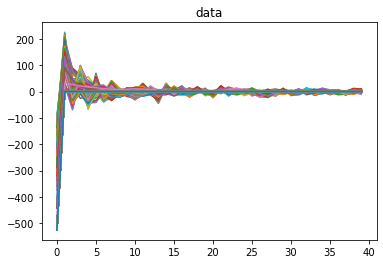

mfcc shape  (40, 151)


In [9]:
Sample1 = df.iloc[4][0]

in_x, sr = librosa.load(Sample1)
data = librosa.feature.mfcc(in_x, sr=sr, n_mfcc = 40)
#data, phase = librosa.magphase(librosa.stft(in_x, n_fft=256))
#scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = scaler.fit(data)
#data = scaler.transform(data)
print('before transform ', data[0][:10])

show_data(data)
ipd.Audio(in_x, rate=sr)
print('mfcc shape ', data.shape)

In [10]:
ipd.Audio(in_x, rate=sr)

In [11]:
# Load files
audio_segment = AudioSegment.from_file(Sample1)

# Print attributes
print(f"Channels: {audio_segment.channels}")
print(f"Sample width: {audio_segment.sample_width}")
print(f"Frame rate (sample rate): {audio_segment.frame_rate}")
print(f"Frame width: {audio_segment.frame_width}")
print(f"Length (ms): {len(audio_segment)}")
print(f"Frame count: {audio_segment.frame_count()}")
print(f"Intensity: {audio_segment.dBFS}")

Channels: 1
Sample width: 2
Frame rate (sample rate): 16000
Frame width: 2
Length (ms): 3500
Frame count: 56000.0
Intensity: -19.965080740194875


(40, 151)


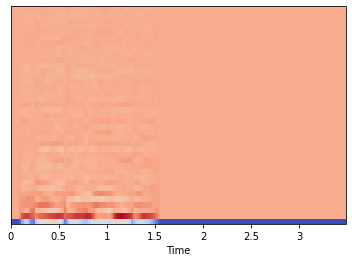

In [12]:
# MFCC
mfcc_1 = librosa.feature.mfcc(in_x, sr=sr, n_mfcc = 40)
print(mfcc_1.shape)

librosa.display.specshow(mfcc_1, sr=sr, x_axis='time')

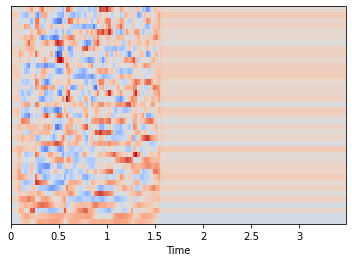

In [13]:
mfccs = sklearn.preprocessing.scale(mfcc_1, axis=1)
#plt.figure(figsize=(20,5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [14]:
print(mfccs)

[[-0.7760798  -0.7760798  -0.7760798  ... -0.7760798  -0.7760798
  -0.7760798 ]
 [-0.74910045 -0.74910045 -0.74910045 ... -0.74910045 -0.74910045
  -0.74910045]
 [ 0.00376905  0.00376905  0.00376905 ...  0.00376905  0.00376905
   0.00376905]
 ...
 [ 0.5151836   0.5151836   0.5151836  ...  0.5151836   0.5151836
   0.5151836 ]
 [-0.095639   -0.095639   -0.095639   ... -0.095639   -0.095639
  -0.095639  ]
 [-0.3483598  -0.3483598  -0.3483598  ... -0.3483598  -0.3483598
  -0.3483598 ]]


[Text(0.5, 1.0, 'log Power spectrogram')]

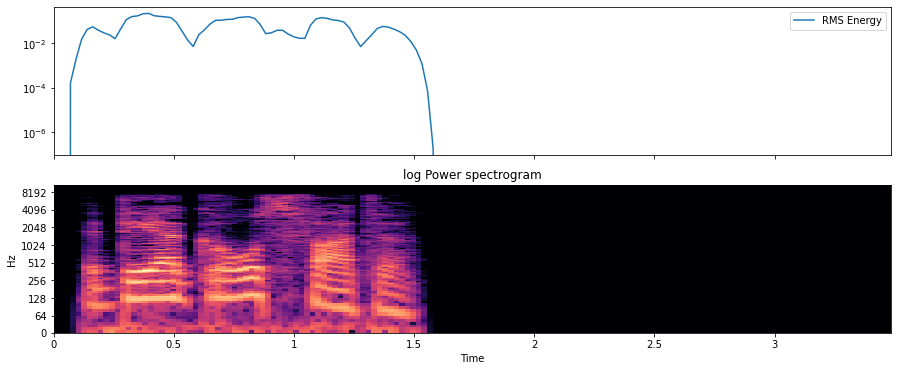

In [15]:
S, phase = librosa.magphase(librosa.stft(in_x))
rms = librosa.feature.rms(S=S)
# Plot the RMS energy
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

In [16]:
S

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
print(mfccs.shape)

(40, 151)


In [18]:
print(S.shape)

(1025, 151)


In [19]:
flat = S.flatten()
print(flat.shape)

(154775,)


In [20]:
print(feat_df.shape)

(198, 4)


In [21]:
print(feat_df.iloc[0])

InFileName                              chunked/Input/Ger-01.wav
Input          [-602.9363, -602.9363, -602.9363, -585.07477, ...
OutFileName                            chunked/Output/Eng-01.wav
Output         [-547.9988, -547.9988, -547.9988, -547.9988, -...
Name: 0, dtype: object


## Modeling

In [22]:
from keras.layers import Dense, Conv1D, Flatten, Input,Activation, Dropout,Bidirectional, LSTM,GRU, BatchNormalization, Masking
from keras.layers import MultiHeadAttention, Concatenate
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split


In [23]:
X = new_input_df
y = new_output_df

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [25]:
print('Input type: ',type(X_train[1]))
print('Input size: ',X_train.shape[1])
print(X_train.shape)
#print('Data',X_train)

Input type:  <class 'pandas.core.series.Series'>
Input size:  6040
(158, 6040)


In [26]:
Y_train.shape[1]

6040

In [36]:
in_shape = X_train.shape[1]
out_shape = Y_train.shape[1]
opt = Adam(lr=0.001)

#Sequential Model 
model = Sequential()
model.add(Conv1D(256, kernel_size=10, input_shape=(in_shape,1)))
model.add(GRU(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(GRU(256, activation='relu'))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(out_shape))
#model.add(Activation('swish'))

# compiling the sequential model
model.compile(loss="mean_squared_error", metrics=['mean_squared_error'], optimizer=opt)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6031, 256)         2816      
                                                                 
 gru_6 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 6040)              1552280   
                                                      

In [37]:
import tensorflow as tf

model_1 = Sequential()
#model_1.add(Masking(mask_value=0, input_shape=(in_shape,1)))
#attention = MultiHeadAttention(num_heads=2, key_dim=2)
#target = tf.keras.Input(in_shape) #Bidirectional(LSTM(124))
#output_tensor, weights = attention(target, target, return_attention_scores=True)
#model_1.add(output_tensor)
model_1.add(Conv1D(256, kernel_size=10, input_shape=(in_shape,1)))
model_1.add(Bidirectional(LSTM(256, return_sequences=True)))
model_1.add(Bidirectional(LSTM(256)))
#model_1.add(Concatenate()([GRU(24),GRU(24)]))
model_1.add(Dense(256))
model_1.add(Dense(in_shape))
#model_1.add(Activation('softmax'))
model_1.compile(loss='mean_squared_error',metrics=['mean_squared_error'] ,optimizer=opt)
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 6031, 256)         2816      
                                                                 
 bidirectional_4 (Bidirectio  (None, 6031, 512)        1050624   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 6040)              1552280   
                                                                 
Total params: 4,311,960
Trainable params: 4,311,960
No

In [38]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'continuous-multioutput'

In [39]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

epochs = 5; batch_size = 1

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=True, validation_data=(X_test, Y_test))

Epoch 1/5
158/158 [==============================] - 578s 4s/step - loss: 4825.2759 - mean_squared_error: 4825.2759 - val_loss: 4793.9521 - val_mean_squared_error: 4793.9521
Epoch 2/5
158/158 [==============================] - 571s 4s/step - loss: 4234.9907 - mean_squared_error: 4234.9907 - val_loss: 3948.4719 - val_mean_squared_error: 3948.4719
Epoch 3/5
158/158 [==============================] - 570s 4s/step - loss: 3298.0085 - mean_squared_error: 3298.0085 - val_loss: 2919.3921 - val_mean_squared_error: 2919.3921
Epoch 4/5
158/158 [==============================] - 608s 4s/step - loss: 2332.7588 - mean_squared_error: 2332.7588 - val_loss: 1975.1980 - val_mean_squared_error: 1975.1980
Epoch 5/5
158/158 [==============================] - 542s 3s/step - loss: 1553.2887 - mean_squared_error: 1553.2887 - val_loss: 1282.4777 - val_mean_squared_error: 1282.4777


In [57]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

epochs = 5; batch_size = 1

history = model_1.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=True, validation_data=(X_test, Y_test))

Epoch 1/5
158/158 [==============================] - 2364s 15s/step - loss: 1044.9648 - mean_squared_error: 1044.9648 - val_loss: 610.1052 - val_mean_squared_error: 610.1052
Epoch 2/5
158/158 [==============================] - 2721s 17s/step - loss: 672.7226 - mean_squared_error: 672.7226 - val_loss: 608.3464 - val_mean_squared_error: 608.3464
Epoch 3/5
158/158 [==============================] - 2572s 16s/step - loss: 656.4075 - mean_squared_error: 656.4075 - val_loss: 562.9801 - val_mean_squared_error: 562.9801
Epoch 4/5
158/158 [==============================] - 2432s 15s/step - loss: 650.7029 - mean_squared_error: 650.7029 - val_loss: 590.0900 - val_mean_squared_error: 590.0900
Epoch 5/5
158/158 [==============================] - 2650s 17s/step - loss: 657.5856 - mean_squared_error: 657.5856 - val_loss: 556.8623 - val_mean_squared_error: 556.8623


## Model Evaluation

In [40]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['mean_squared_error']
    val_acc = history.history['val_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training mse')
    plt.plot(x, val_acc, 'r', label='Validation msc')
    plt.title('Training and validation MSE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

5/5 [==============================] - 11s 2s/step - loss: 1249.4346 - mean_squared_error: 1249.4346
Training MSE: 1249.4346
Training RMSE 35.34734177151798
2/2 [==============================] - 3s 778ms/step - loss: 1282.4775 - mean_squared_error: 1282.4775
Testing MSE:  1282.4775
Testing RMSE 35.8116955625184


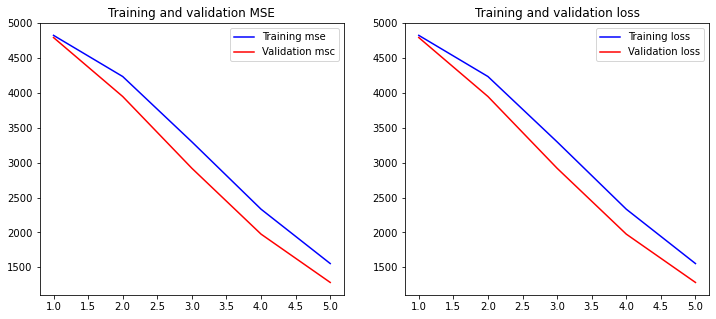

In [41]:
from sklearn.metrics import mean_squared_error

#print("MSE",mean_squared_error(Y_test,Y_pred))
#print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

loss, train_mse = model.evaluate(X_train, Y_train, verbose=True)
print("Training MSE: {:.4f}".format(train_mse))
print("Training RMSE",np.sqrt(train_mse))
loss, test_mse = model.evaluate(X_test, Y_test, verbose=True)
print("Testing MSE:  {:.4f}".format(test_mse))
print("Testing RMSE",np.sqrt(test_mse))
plot_history(history)

5/5 [==============================] - 77s 14s/step - loss: 632.7614 - mean_squared_error: 632.7614
Training MSE: 632.7614
Training RMSE 25.15474811122271
2/2 [==============================] - 20s 6s/step - loss: 556.8622 - mean_squared_error: 556.8622
Testing MSE:  556.8622
Testing RMSE 23.597927506821176


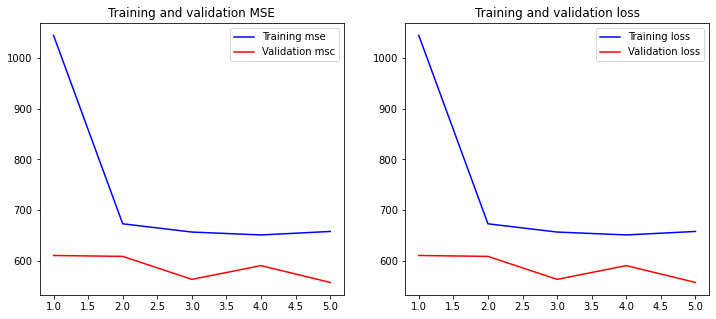

In [58]:
from sklearn.metrics import mean_squared_error

#print("MSE",mean_squared_error(Y_test,Y_pred))
#print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

loss, train_mse = model_1.evaluate(X_train, Y_train, verbose=True)
print("Training MSE: {:.4f}".format(train_mse))
print("Training RMSE",np.sqrt(train_mse))
loss, test_mse = model_1.evaluate(X_test, Y_test, verbose=True)
print("Testing MSE:  {:.4f}".format(test_mse))
print("Testing RMSE",np.sqrt(test_mse))
plot_history(history)

## Deployment

In [153]:
!pip3 install h5py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [65]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


os.chdir('/Users/admin/DBS_Assisgnments/Sem 2/DeepLearning/CA01')
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [63]:
# serialize model to JSON
model_json = model_1.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_1.save_weights("model_1.h5")
print("Saved model to disk")

Saved model to disk


In [66]:
from keras.models import model_from_json
os.chdir('/Users/admin/DBS_Assisgnments/Sem 2/DeepLearning/CA01')
# load json and create model
json_file = open('model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_1.h5")
print("Loaded model from disk")

Loaded model from disk


In [67]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error']) #'rmsprop'
score = loaded_model.evaluate(X_test, Y_test, verbose=0)

In [68]:
print("%s: %.2f" % (loaded_model.metrics_names[1], score[1]))
print("%s: %.2f" % ('RMSE', np.sqrt(score[1])))

mean_squared_error: 556.86
RMSE: 23.60


In [69]:
test_1 = 'chunked/test/Input/Ger-01.wav'
pred_1 =  'chunked/test/Input/Eng-01.wav'

In [70]:
add_silence(test_1,test_1,3500)

In [71]:
from sklearn.preprocessing import StandardScaler

'''def feature(fileName):
  add_silence(fileName)
  x, sr = librosa.load(fileName)
  data = librosa.feature.mfcc(x) #, sr=sr, n_mfcc = 40)
  scaler = StandardScaler()
  scaler = scaler.fit(data)
  data = scaler.transform(data)
  flat = data.flatten()
  return flat'''

#test1 =[]
#pred1 = []
#new_test = 'chunked/added/Test_Ger_sil-01.wav'
test1 = pd.DataFrame()
pred1 = pd.DataFrame()
for i in range(1):
    test1 = test1.append(pd.DataFrame([feat(test_1,'mfcc')]), ignore_index=True)
    pred1 = pred1.append(pd.DataFrame([feat(pred_1,'mfcc')]), ignore_index=True)
    #test1.append(feature(test_1))
    #pred1.append(feature(pred_1))

In [72]:
test1.shape

(1, 6040)

In [73]:
import time 
start = time.time()
#print('Before :', start)
pred11 = loaded_model.predict(test1)
#pred11 = model_1.predict(test1)
print('Time taken to process :', time.time()-start)

Time taken to process : 3.124617338180542


In [74]:
deFlat =  np.reshape(pred11,(40,151))

In [75]:
deFlat.shape

(40, 151)

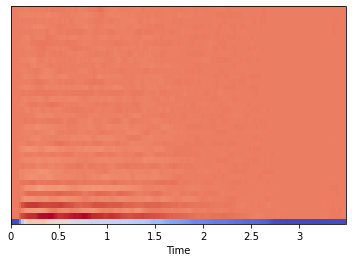

In [76]:
librosa.display.specshow(deFlat, sr=sr, x_axis='time')

In [77]:
recovered = librosa.feature.inverse.mfcc_to_audio(deFlat ,n_mels=40)

Predicted by model

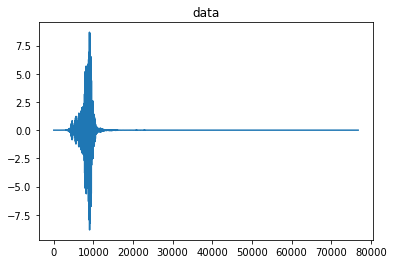

In [78]:
#x, sr = librosa.load(pred_1)
data = librosa.feature.mfcc(recovered)
wav1 = librosa.feature.inverse.mfcc_to_audio(data, n_mels = 40)
show_data(wav1)
ipd.Audio(recovered, rate=sr)

Actual utterance

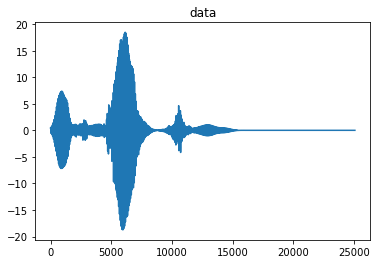

In [212]:
x, sr = librosa.load(pred_1)
data = librosa.feature.mfcc(x)
wav = librosa.feature.inverse.mfcc_to_audio(data, n_mels = 20)
show_data(wav)
ipd.Audio(wav, rate=sr)

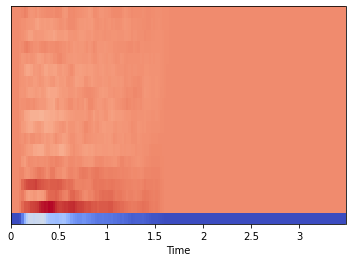

In [79]:
librosa.display.specshow(data, sr=sr, x_axis='time')

## Conclusion

#### According to the results obtained here are some observation 

* #### Model 1 has 2,016,664 parameter and tries to reach better RMSE as the number of epoch increases.
    
    *  Time taken to train one Batch of data is 4 sec X Trainable input rows.   

* #### Model 2 has 4,311,960 parameter which is double the weight of Model 1, but the reaching the optimal RMSE with less number of epoch compared to Model 1.
    *  Time taken to train one Batch of data is 18 sec X Trainable input rows.

From the obtained results we can conclude Model 2 which uses Bidirectional LSTM performed much better, if we do not consider Time complexity

### References

* D. Yu and L. Deng, "Automatic Speech Recognition," 2015, doi: 10.1007/978-1-4471-5779-3.

* S. H. Limbu, "Direct Speech to Speech Translation Using Machine Learning," 2020, Accessed: Apr. 11, 2022. [Online]. Available: http://www.teknat.uu.se/student

* "Google AI Blog: Introducing Translatotron: An End-to-End Speech-to-Speech Translation Model." https://ai.googleblog.com/2019/05/introducing-translatotron-end-to-end.html (accessed Apr. 06, 2022).

* "Google AI Blog: Introducing Translatotron: An End-to-End Speech-to-Speech Translation Model." https://ai.googleblog.com/2019/05/introducing-translatotron-end-to-end.html (accessed Apr. 11, 2022).

* "Google AI Blog: High-Quality, Robust and Responsible Direct Speech-to-Speech Translation." https://ai.googleblog.com/2021/09/high-quality-robust-and-responsible.html (accessed Apr. 13, 2022).

* N. Moritz, T. Hori, and J. le Roux, "STREAMING AUTOMATIC SPEECH RECOGNITION WITH THE TRANSFORMER MODEL".

* A. Gholami, S. Kim, Z. Dong, Z. Yao, M. W. Mahoney, and K. Keutzer, "A Survey of Quantization Methods for Efficient Neural Network Inference".

* Y. Jiao, A. Gabry´sgabry´s, G. Tinchev, B. Putrycz, D. Korzekwa, and V. Klimkov, “UNIVERSAL NEURAL VOCODING WITH PARALLEL WAVENET,” 2021.

* A. Lee et al., "Direct Speech-to-Speech Translation With Discrete Units".